<a href="https://colab.research.google.com/github/danjohnvelasco/course-v3/blob/master/nbs/dl1/lesson2-sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
from fastai.basics import *

In this part of the lecture we explain Stochastic Gradient Descent (SGD) which is an **optimization** method commonly used in neural networks. We will illustrate the concepts with concrete examples.

#  Linear Regression problem

The goal of linear regression is to fit a line to a set of points.

In [2]:
n=100

In [3]:
x = torch.ones(n,2) 
x[:,0].uniform_(-1.,1)
x[:5]

tensor([[ 0.7816,  1.0000],
        [ 0.9712,  1.0000],
        [ 0.5298,  1.0000],
        [ 0.8111,  1.0000],
        [-0.1494,  1.0000]])

In [4]:
a = tensor(3.,2); a

tensor([3., 2.])

In [5]:
tensor??

In [10]:
# Add noise
y = x@a + 0.25*torch.randn(n)

#Uncomment to see plot w/o noise
#y = x@a

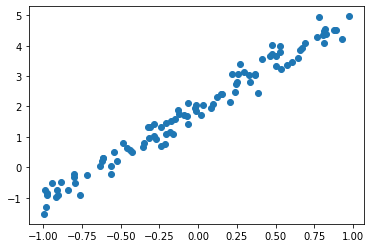

In [11]:
plt.scatter(x[:,0], y);

You want to find **parameters** (weights) `a` such that you minimize the *error* between the points and the line `x@a`. Note that here `a` is unknown. For a regression problem the most common *error function* or *loss function* is the **mean squared error**. 

In [12]:
# y_hat == predictions
# y == actual
def mse(y_hat, y): return ((y_hat-y)**2).mean()

Suppose we believe `a = (-1.0,1.0)` then we can compute `y_hat` which is our *prediction* and then compute our error.

In [13]:
a = tensor(-1.,1)

In [14]:
y_hat = x@a
mse(y_hat, y)

tensor(5.7860)

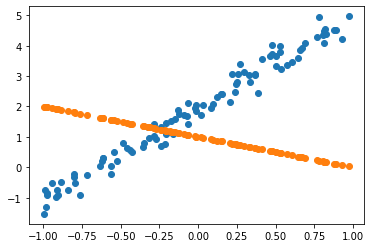

In [15]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],y_hat);

So far we have specified the *model* (linear regression) and the *evaluation criteria* (or *loss function*). Now we need to handle *optimization*; that is, how do we find the best values for `a`? How do we find the best *fitting* linear regression.

# Gradient Descent

We would like to find the values of `a` that minimize `mse_loss`.

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here is gradient descent implemented in [PyTorch](http://pytorch.org/).

In [16]:
a = nn.Parameter(a); a

Parameter containing:
tensor([-1.,  1.], requires_grad=True)

In [28]:
mse??

In [34]:
mse(y, y_hat)

tensor(5.7860)

Notice that mse should return a scalar...
BUT IT'S A SCALAR IN THE FORM OF A TENSOR OBJECT

In [37]:
help(torch.Tensor.backward)

Help on function backward in module torch.tensor:

backward(self, gradient=None, retain_graph=None, create_graph=False)
    Computes the gradient of current tensor w.r.t. graph leaves.
    
    The graph is differentiated using the chain rule. If the tensor is
    non-scalar (i.e. its data has more than one element) and requires
    gradient, the function additionally requires specifying ``gradient``.
    It should be a tensor of matching type and location, that contains
    the gradient of the differentiated function w.r.t. ``self``.
    
    This function accumulates gradients in the leaves - you might need to zero
    ``.grad`` attributes or set them to ``None`` before calling it.
    See :ref:`Default gradient layouts<default-grad-layouts>`
    for details on the memory layout of accumulated gradients.
    
    Arguments:
        gradient (Tensor or None): Gradient w.r.t. the
            tensor. If it is a tensor, it will be automatically converted
            to a Tensor that does

In [42]:
# here's a model/architecture:  y = x@a (aka y = mx + b)
# here's the preds
# then here's the loss function
# chug it with preds and actual
# compute the gradient of the loss function
# subtract that gradient*learning_rate to the current weight/parameter/coefficient
# reset grad to zero to prevent accumulating gradients

def update():
    '''updates vector a'''
    y_hat = x@a
    loss = mse(y, y_hat) # returns Tensor scalar
    if t % 10 == 0: print(loss)
    loss.backward() # computes gradient of current tensor wrt to graph leaves (need to dig into this)
    with torch.no_grad():
        a.sub_(lr * a.grad)
        a.grad.zero_() # reset grad to zero because torch accumulates grad.. you don't want to reuse it

In [39]:
torch.no_grad??

In [24]:
lr = 1e-1
for t in range(100): update()

tensor(5.7860, grad_fn=<MeanBackward0>)
tensor(1.5114, grad_fn=<MeanBackward0>)
tensor(0.4709, grad_fn=<MeanBackward0>)
tensor(0.1839, grad_fn=<MeanBackward0>)
tensor(0.1044, grad_fn=<MeanBackward0>)
tensor(0.0823, grad_fn=<MeanBackward0>)
tensor(0.0762, grad_fn=<MeanBackward0>)
tensor(0.0745, grad_fn=<MeanBackward0>)
tensor(0.0740, grad_fn=<MeanBackward0>)
tensor(0.0739, grad_fn=<MeanBackward0>)


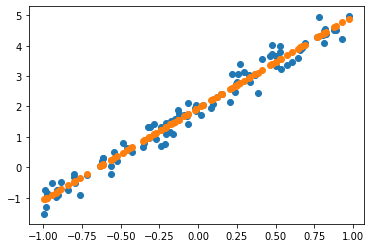

In [40]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],x@a.detach());

## Animate it!

In [41]:
from matplotlib import animation, rc
rc('animation', html='jshtml') #jshtml for colab

In [43]:
help(torch.Tensor.detach)

Help on method_descriptor:

detach(...)
    Returns a new Tensor, detached from the current graph.
    
    The result will never require gradient.
    
    .. note::
    
      Returned Tensor shares the same storage with the original one.
      In-place modifications on either of them will be seen, and may trigger
      errors in correctness checks.
      IMPORTANT NOTE: Previously, in-place size / stride / storage changes
      (such as `resize_` / `resize_as_` / `set_` / `transpose_`) to the returned tensor
      also update the original tensor. Now, these in-place changes will not update the
      original tensor anymore, and will instead trigger an error.
      For sparse tensors:
      In-place indices / values changes (such as `zero_` / `copy_` / `add_`) to the
      returned tensor will not update the original tensor anymore, and will instead
      trigger an error.



In [48]:
a = nn.Parameter(tensor(-1.,1)) # arbitrary starting point

fig = plt.figure()
plt.scatter(x[:,0], y, c='orange')
line, = plt.plot(x[:,0], x@a.detach())
plt.close()

def animate(i):
    update()
    line.set_ydata(x@a.detach()) # .detach detaches from the current graph
    return line,

animation.FuncAnimation(fig, animate, np.arange(0, 100), interval=100)

In practice, we don't calculate on the whole file at once, but we use *mini-batches*.

## Vocab

- Learning rate
- Epoch
- Minibatch
- SGD
- Model / Architecture
- Parameters
- Loss function

For classification problems, we use *cross entropy loss*, also known as *negative log likelihood loss*. This penalizes incorrect confident predictions, and correct unconfident predictions.